In [1]:
%load_ext autoreload
%autoreload 2

# Counterfactual explanations for the GSMarena dataset

## Installations and imports

In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [4]:
import math
import os
import os.path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight


from utils import util_data, util_models, util_plot

kaggle.json not found, you cannot use kaggle module.


In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

## Load the dataset

We load the previously processed datasets, such that we can train the model with them.

In [6]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)

df_train.head(3)

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
1501,0,0.840703,0.923432,-0.759706,-0.667155,0.000000,0.000000,1.0,1.0,0.0,0,1,0,1,0,0,0,0
1193,1,0.928887,0.427140,0.589274,1.371239,0.976324,1.012555,2.0,1.0,1.0,0,1,0,1,1,0,0,0
477,1,0.242524,1.009706,-0.759706,-0.667155,0.976324,0.000000,2.0,1.0,1.0,0,1,0,1,0,0,0,0


In [7]:
# Show duplicated rows
def get_dup_rows(df, drop_cols):
    dup_rows = df[df.duplicated(subset=df.columns.drop(drop_cols), keep=False)]
    return dup_rows

get_dup_rows(df_train, ["misc_price"])

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof


This dataset doesn't contain null values or duplicates since it is preprocessed.

In [8]:
print(f"Null values:{df_train.isna().sum().sum()}")
print(f"Number of duplicated rows: {df_train.duplicated().sum()}")
print(f"Number of samples for training: {df_train.shape[0]}")
print(f"Number of samples for test: {df_test.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of samples for training: 1521
Number of samples for test: 383


We know that the dataset is very imbalanced, this makes sense given that the majority of smartphones are in the low price range, because everyone can afford it. To deal with this problem, during training we will use some weights for each class, considering the inverse of the frequencies.

In [9]:
util_data.count_frequency_labels(df_train.misc_price).sort_index()

,Frequency,Count
0,48.72%,741
1,37.28%,567
2,14.00%,213


### Train, validation, test split for the model

We split the dataset in train and test such that we can evaluate the model after the training.

In [11]:
print(f"Train dataset: {df_train.shape}, Test dataset: {df_test.shape}")

Train dataset: (1521, 18), Test dataset: (383, 18)


In [13]:
X_train_val, y_train_val = df_train.drop("misc_price", axis=1), df_train.misc_price
X_test, y_test = df_test.drop("misc_price", axis=1), df_test.misc_price

print(f"X_train_val: {X_train_val.shape}, y_train_val: {y_train_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train_val: (1521, 17), y_train_val: (1521,)
X_test: (383, 17), y_test: (383,)


Afterwards we further split the training dataset to create an evaluation one and check during the training the accuracy of the model.

In [13]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=rng)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (1216, 17), y_train: (1216,)
X_val: (305, 17), y_val: (305,)


## The model, a neural network

The main objective of this project is to produce a counterfactual explanation and to study different existent methods for producing counterfactuals. The OMLT library, to the best of our knowledge, does not support the creation of an optimization model for a multi-class classification problem using trees (DTs, RandomForest, XGBoost, etc) yet.

In order to pursue our goal and to manually write the constraints to create the counterfactuals and the objective functions, we decided to use a very simple neural network, even if it may not be the best choice for this problem.

### Initialize model

We will use the PyTorch framework to create the network and to train the model.

In [11]:
import torch
import torchsummary

Set some values for the training of the network and create the neural network model.

In [14]:
EPOCHS = 100
BATCH_SIZE = 1024
LR = 0.005
N_SPLITS = 5
DROPOUT_RATE = 0.2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

num_features = X_train_val.shape[1]
num_class = len(np.unique(y_train_val))
hidden_layers = [64, 64]

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class, dropout_rate=DROPOUT_RATE).to(device)

Device: cpu
Train weights: tensor([0.6842, 0.8942, 2.3803])


Check the architecture of the model.

In [39]:
nn_summary = torchsummary.summary(nn_model, (BATCH_SIZE, num_features), verbose=0);
nn_summary.input_size = None
print(nn_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1024, 64]            1,152
├─ReLU: 1-2                              [-1, 1024, 64]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1024, 64]            4,160
├─ModuleList: 1                          []                        --
|    └─Dropout: 2-2                      [-1, 1024, 64]            --
├─ReLU: 1-3                              [-1, 1024, 64]            --
├─Linear: 1-4                            [-1, 1024, 3]             195
Total params: 5,507
Trainable params: 5,507
Non-trainable params: 0


We created a class to train the model and automatize different processes, therefore we initialize an instance of this class and we compute the weights for each class, as explained before.

In [ ]:
train_test = util_models.TrainTestNetwork(nn_model, util_models.multi_acc, device, SEED)
weights = util_models.compute_inverse_class_frequency(y_train_val.values, device)
weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train_val), y=y_train_val)
weights = torch.tensor(weights, dtype=torch.float).to(device)

path_save_model = "models/nn_model.pt"

print(f"Train weights: {weights}")

If there is already a checkpoint for the weights of the model we can load it, otherwise we should train our model.

In [21]:
checkpoint = torch.load(path_save_model)
nn_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Training and evaluation of the model

We trained the model with holdout and using k-fold to estimate its accuracy, in both cases we used the weights for the classes and we computed the balanced accuracy. To find the best set of hyperparameters for the model we ran a random search on a narrow set of values.

During the training we saved the best weights for the model such that we can reuse it for the evaluation.

#### Holdout

In [106]:
train_data = (X_train.values, y_train.values)
val_data = (X_val.values, y_val.values)

losses, accuracies = train_test.train_model(
    train_data,
    val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    print_every=EPOCHS,
    reset_weights=True,
    ce_weights=weights,
    max_metric=0.74,
    weight_decay=0.08,
    reduce_lr=False,
    cosine_annealing=True,
    cosine_t0=20,
    cosine_tmult=3,
    name_model=path_save_model,
)

max_i, max_acc = np.argmax(accuracies["val"]), np.max(accuracies["val"])
print(f"\nMax accuracy {max_acc:.3f} at epoch {max_i+1}")

Model saved with accuracy: 0.743 at epoch 22
Model saved with accuracy: 0.743 at epoch 31
Model saved with accuracy: 0.755 at epoch 33
Epoch 090: | Loss: 0.47742 | Acc: 0.808 | Val loss: 0.63314 | Acc: 0.746

Max accuracy 0.755 at epoch 33


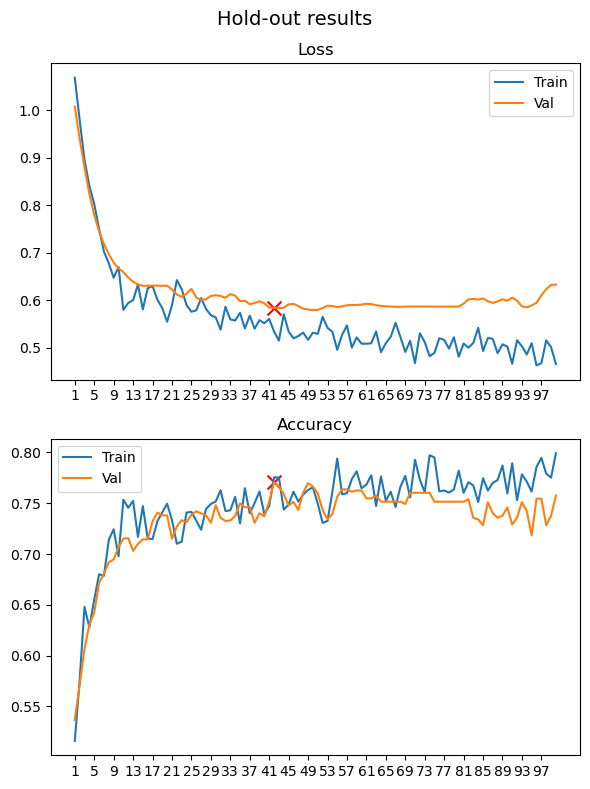

In [99]:
# TODO: move to a function
fig, axs = plt.subplots(2, figsize=(6, 4 * 2))

fig.suptitle("Hold-out results", fontsize=14)
util_plot.plot_model_results(axs[0], EPOCHS, losses, f"Loss")
axs[0].scatter(max_i + 1, losses["val"][max_i], marker="x", color="red", s=100, label=f"Min loss {losses['val'][max_i]:.3f} at epoch {max_i+1}")
util_plot.plot_model_results(axs[1], EPOCHS, accuracies, f"Accuracy")
axs[1].scatter(max_i + 1, max_acc, marker="x", color="red", s=100, label=f"Max accuracy {max_acc:.3f} at epoch {max_i+1}")

fig.tight_layout()

#### K-FOLD

In [265]:
n_losses, n_accuracies = train_test.kfold_train_model(
    X_train_val.values,
    y_train_val.values,
    N_SPLITS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    print_every=EPOCHS,
    reset_weights=True,
    ce_weights=weights,
    max_metric=0.75,
    weight_decay=0.04,
    reduce_lr=False,
    cosine_annealing=True,
    cosine_t0=20,
    cosine_tmult=2,
)

for i, acc in enumerate(n_accuracies):
    max_i, max_acc = np.argmax(acc["val"]), np.max(acc["val"])
    print(f"Fold {i+1}: Max accuracy {max_acc:.3f} at epoch {max_i}")


Epoch 100: | Loss: 0.26124 | Acc: 0.898 | Val loss: 1.24626 | Acc: 0.699
kfold on group 1 accuracy:  0.6989

Epoch 100: | Loss: 0.29904 | Acc: 0.885 | Val loss: 1.28012 | Acc: 0.707
kfold on group 2 accuracy:  0.7072

Max accuracy so far: 0.753 at epoch 11
Max accuracy so far: 0.764 at epoch 13
Epoch 100: | Loss: 0.29464 | Acc: 0.881 | Val loss: 0.84408 | Acc: 0.705
kfold on group 3 accuracy:  0.7055

Max accuracy so far: 0.778 at epoch 10
Max accuracy so far: 0.779 at epoch 11
Model saved with accuracy: 0.789 at epoch 38
Model saved with accuracy: 0.805 at epoch 42
Epoch 100: | Loss: 0.38467 | Acc: 0.831 | Val loss: 0.72510 | Acc: 0.738
kfold on group 4 accuracy:  0.7377

Epoch 100: | Loss: 0.27320 | Acc: 0.898 | Val loss: 1.16118 | Acc: 0.724
kfold on group 5 accuracy:  0.7236

Fold 1: Max accuracy 0.749 at epoch 36
Fold 2: Max accuracy 0.749 at epoch 22
Fold 3: Max accuracy 0.764 at epoch 12
Fold 4: Max accuracy 0.805 at epoch 41
Fold 5: Max accuracy 0.761 at epoch 34


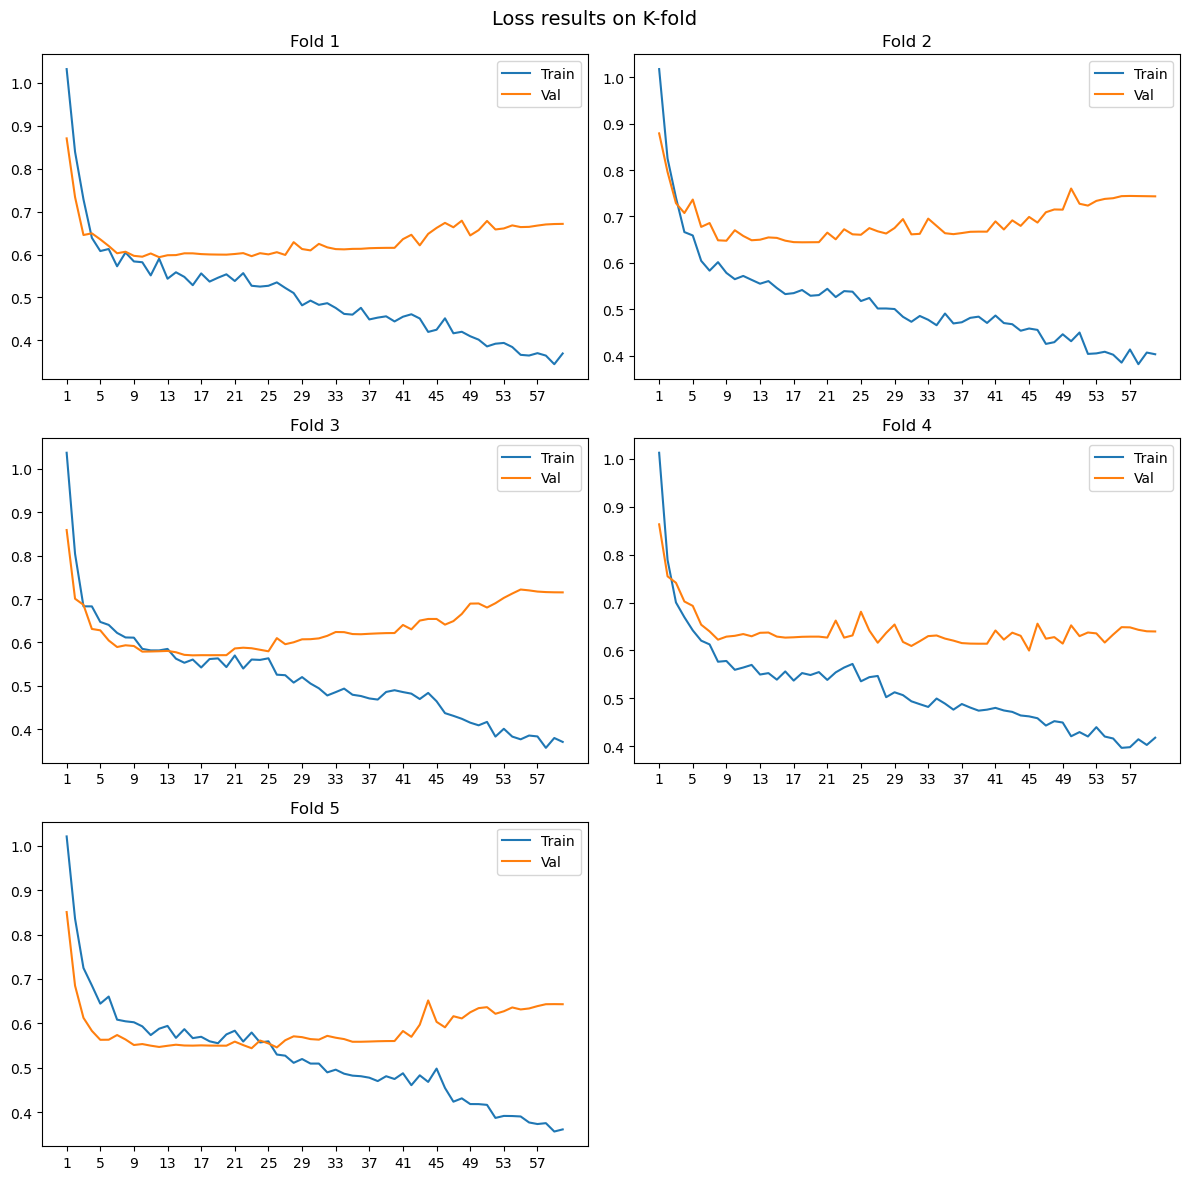

In [230]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Loss results on K-fold", fontsize=14)
for i, losses in enumerate(n_losses):
    util_plot.plot_model_results(faxs[i], EPOCHS, losses, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.tight_layout()

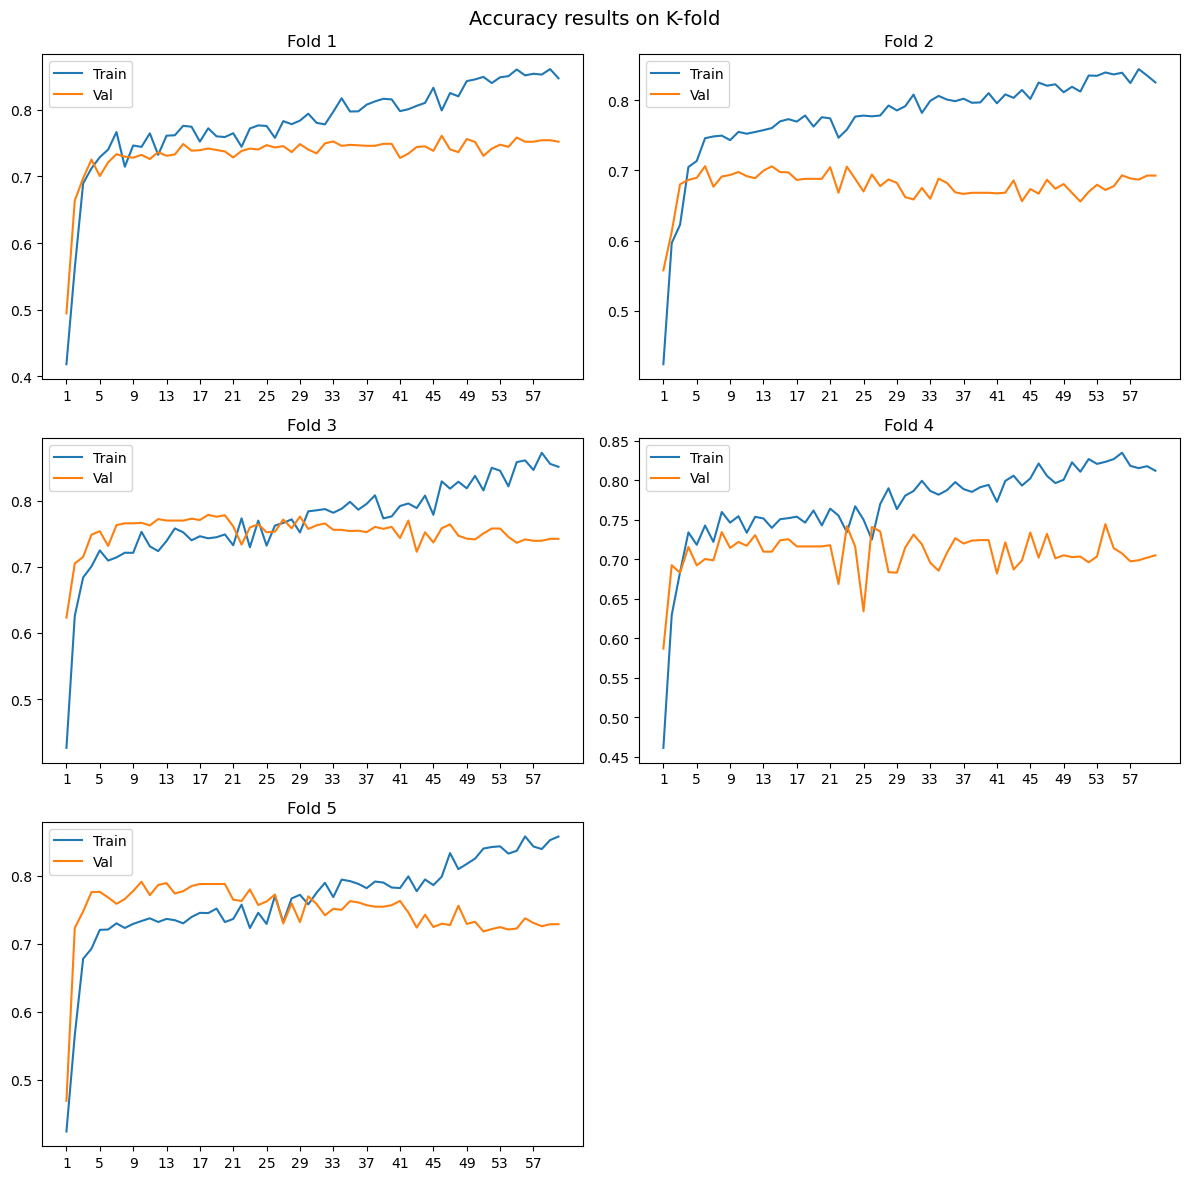

In [231]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Accuracy results on K-fold", fontsize=14)
for i, accuracies in enumerate(n_accuracies):
    util_plot.plot_model_results(faxs[i], EPOCHS, accuracies, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

plt.tight_layout()

#### Random search



Iteration 1
Epoch 100: | Loss: 0.30963 | Acc: 0.887 | Val loss: 0.76572 | Acc: 0.730
kfold on group 1 accuracy:  0.7301

Epoch 100: | Loss: 0.30108 | Acc: 0.893 | Val loss: 0.84694 | Acc: 0.678
kfold on group 2 accuracy:  0.6777

Epoch 100: | Loss: 0.31605 | Acc: 0.869 | Val loss: 0.90323 | Acc: 0.722
kfold on group 3 accuracy:  0.7220

Epoch 100: | Loss: 0.31347 | Acc: 0.886 | Val loss: 0.78593 | Acc: 0.717
kfold on group 4 accuracy:  0.7173

Epoch 100: | Loss: 0.28427 | Acc: 0.898 | Val loss: 0.87323 | Acc: 0.708
kfold on group 5 accuracy:  0.7078

Fold 1: Max accuracy 0.753 at epoch 65.0
Fold 1: Max accuracy 0.713 at epoch 16.0
Fold 1: Max accuracy 0.770 at epoch 12.0
Fold 1: Max accuracy 0.744 at epoch 72.0
Fold 1: Max accuracy 0.783 at epoch 10.0


Iteration 2
Epoch 100: | Loss: 0.39864 | Acc: 0.840 | Val loss: 0.66067 | Acc: 0.727
kfold on group 1 accuracy:  0.7267

Epoch 100: | Loss: 0.37132 | Acc: 0.854 | Val loss: 0.86252 | Acc: 0.687
kfold on group 2 accuracy:  0.6867

Epoc

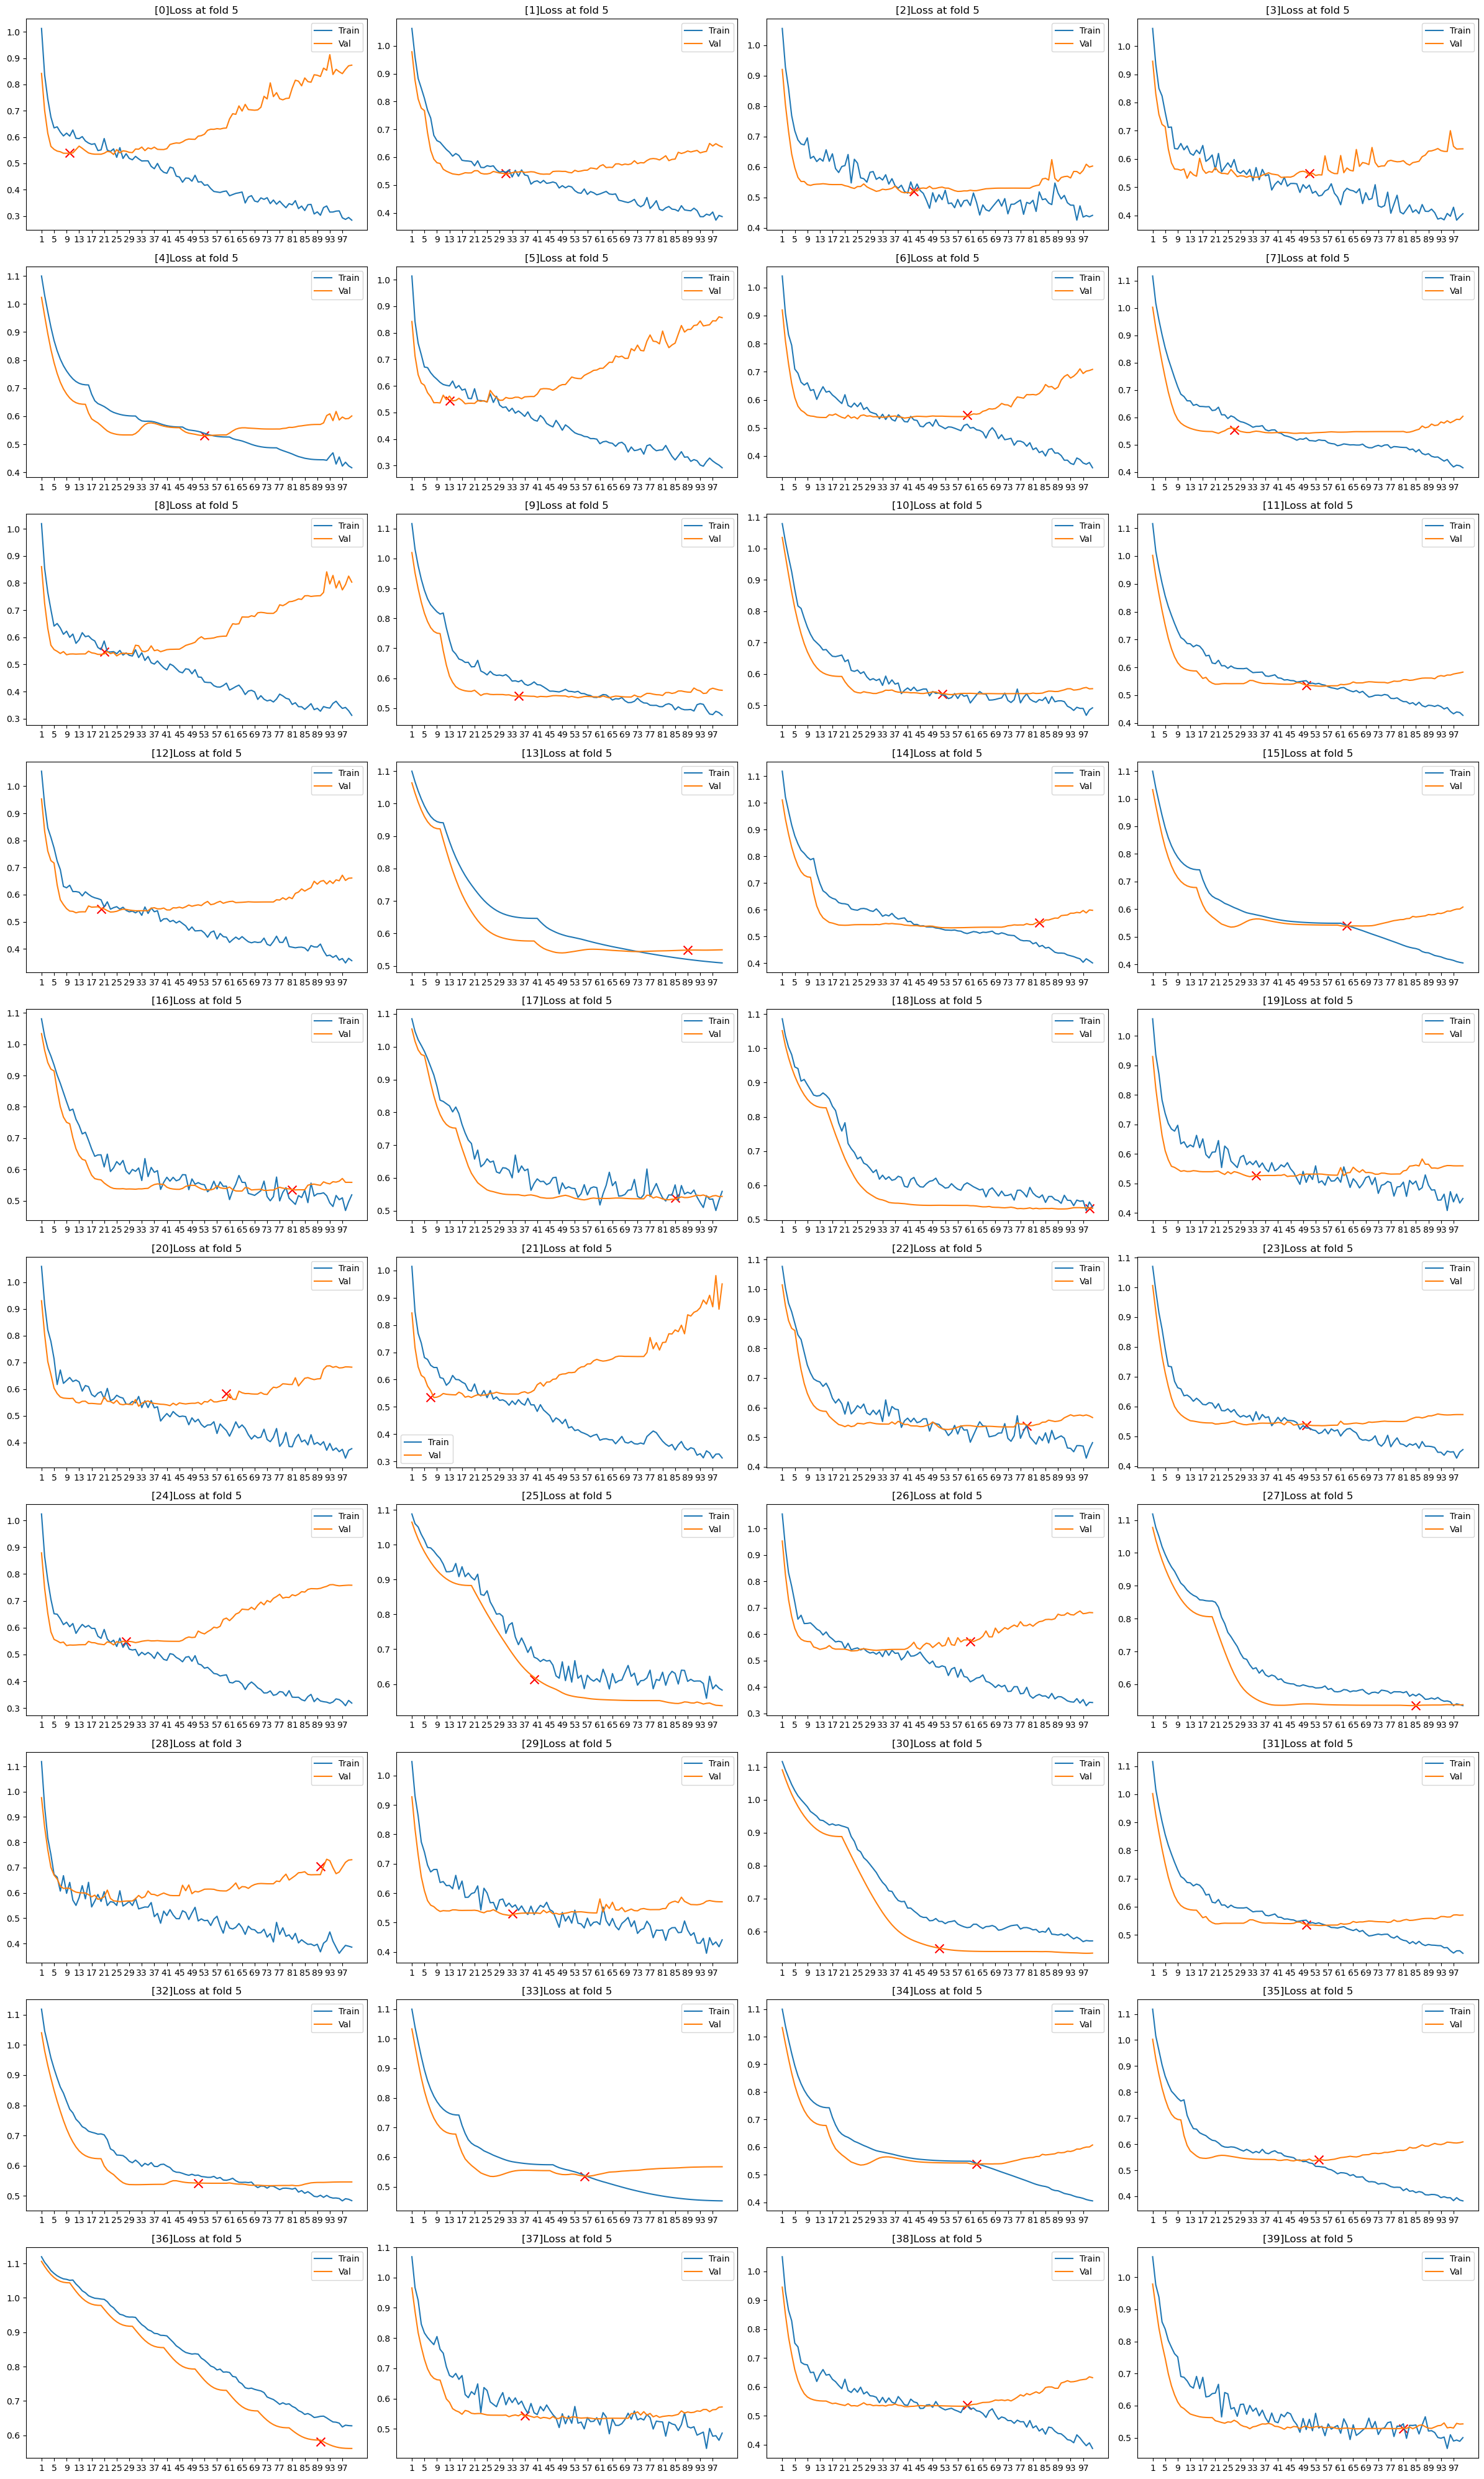

In [72]:
# Random values
# lr_int = [0.005]
lr_int = np.linspace(0.001, 0.01, num=10)
batch_int = [512, 1024, 2048]
# batch_int = [512, 1024, 2048]
dropout = [0, 0.1, 0.2, 0.3]
hidden_dim = [64]
num_layers = [2]
cosine_t0 = np.arange(5, 21, step=5)
cosine_tmult = np.arange(1, 4, step=1)
weight_decay = np.linspace(0.01, 0.1, num=10)

# Fixed values
epochs = 100
num_features = X_train_val.shape[1]
num_class = len(np.unique(y_train_val))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train_val), y=y_train_val)
weights = torch.tensor(weights, dtype=torch.float).to(device)

train_data = (X_train.values, y_train.values)
val_data = (X_val.values, y_val.values)

fig, axs = plt.subplots(10, 4, figsize=(6 * 4, 4 * 10))
faxs = axs.ravel()

saved_iter = pd.DataFrame(columns=
                          ["lr", "batch", "dropout", "t0", "tmult", "weight_decay", "max_acc_std", "max_acc_mean"] +
                          [f"max_acc_{i}" for i in range(N_SPLITS)] +
                          [f"epoch_max_acc_{i}" for i in range(N_SPLITS)])

for i in range(40):
    lr_value = np.random.choice(lr_int)
    batch_value = int(np.random.choice(batch_int))
    dropout_value = np.random.choice(dropout)
    hidden_value = np.random.choice(hidden_dim)
    num_layers_value = np.random.choice(num_layers)
    cosine_t0_value = int(np.random.choice(cosine_t0))
    cosine_tmult_value = int(np.random.choice(cosine_tmult))
    weight_decay_value = np.random.choice(weight_decay)

    hidden_layers = [hidden_value] * num_layers_value

    print(f"\n\nIteration {i+1}")
    # print(f"Learning rate: {lr_value}")
    # print(f"Batch size: {batch_value}")
    # print(f"Dropout: {dropout_value}")
    # print(f"Hidden layers: {hidden_layers}")
    # print(f"Cosine t0: {cosine_t0_value}")
    # print(f"Cosine tmult: {cosine_tmult_value}")
    # print(f"Weight decay: {weight_decay_value}")

    nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class, dropout_rate=dropout_value).to(device)

    train_test = util_models.TrainTestNetwork(nn_model, util_models.multi_acc, device, SEED)

    kwargs_model = {
        "epochs": epochs,
        "batch_size": batch_value,
        "lr": lr_value,
        "print_every": epochs,
        "reset_weights": True,
        "ce_weights": weights,
        "max_metric": 0.80,
        "weight_decay": weight_decay_value,
        "reduce_lr": False,
        "cosine_annealing": True,
        "cosine_t0": cosine_t0_value,
        "cosine_tmult": cosine_tmult_value,
        "name_model": "random_search.pt"
    }

    n_losses, n_accuracies = train_test.kfold_train_model(
        X_train_val.values, y_train_val.values,
        n_splits=N_SPLITS, **kwargs_model
    )

    val_accuracies = np.array([(np.argmax(accuracy["val"]), max(accuracy["val"])) for accuracy in n_accuracies])

    iter_series = pd.Series({
        "lr": lr_value,
        "batch": batch_value,
        "dropout": dropout_value,
        "t0": cosine_t0_value,
        "tmult": cosine_tmult_value,
        "weight_decay": weight_decay_value,
        "max_acc_std": np.std(val_accuracies[:, 1]),
        "max_acc_mean": np.mean(val_accuracies[:, 1]),
        **{f"max_acc_{i}": val_accuracies[i, 1] for i in range(N_SPLITS)},
        **{f"epoch_max_acc_{i}": val_accuracies[i, 0] for i in range(N_SPLITS)}
    }, name=i)

    saved_iter = pd.concat([saved_iter, iter_series.to_frame().T], axis=0)

    for idx, (max_i, max_acc) in enumerate(val_accuracies):
        print(f"Fold {i+1}: Max accuracy {max_acc:.3f} at epoch {max_i}")

    idx_max_fold = np.argmax(val_accuracies[:, 1])
    best_i_acc = int(val_accuracies[idx_max_fold][0])
    loss_best_i_acc = n_losses[idx_max_fold]["val"][best_i_acc]
    
    util_plot.plot_model_results(faxs[i], epochs, n_losses[idx_max_fold], f"[{i}]Loss at fold {idx_max_fold+1}")
    faxs[i].scatter(best_i_acc, loss_best_i_acc, color="red", marker="x", s=100)


fig.tight_layout()

In [84]:
saved_sort = saved_iter.sort_values(by=["max_acc_std", "max_acc_mean"], ascending=True)
filter_index = [[0, 1, 3, 5, 6, 8, 12, 20, 21, 24, 26, 28], [17, 18, 25, 36, 39]]

def color_background(x, filter_cond, color):
    assert len(filter_cond) == len(color)
    for i in range(len(filter_cond)):
        if x.name in filter_cond[i]:
            return [f"background-color: {color[i]}; opacity: 0.2"] * len(x)
    return [""] * len(x)

saved_sort.style.apply(color_background, axis=1, filter_cond=filter_index, color=["#ff0000", "#00ff00"])

,lr,batch,dropout,t0,tmult,weight_decay,max_acc_std,max_acc_mean,max_acc_0,max_acc_1,max_acc_2,max_acc_3,max_acc_4,epoch_max_acc_0,epoch_max_acc_1,epoch_max_acc_2,epoch_max_acc_3,epoch_max_acc_4
19,0.009000,1024.000000,0.300000,20.000000,1.000000,0.090000,0.017946,0.759610,0.749698,0.732987,0.767109,0.761375,0.786883,26.000000,68.000000,40.000000,83.000000,34.000000
29,0.009000,1024.000000,0.200000,20.000000,1.000000,0.060000,0.018751,0.759226,0.755982,0.733184,0.768255,0.749575,0.789135,90.000000,81.000000,43.000000,83.000000,33.000000
30,0.002000,2048.000000,0.300000,20.000000,3.000000,0.020000,0.019185,0.744427,0.735661,0.717836,0.754979,0.738976,0.774683,48.000000,40.000000,88.000000,97.000000,51.000000
25,0.001000,1024.000000,0.100000,20.000000,3.000000,0.050000,0.019288,0.742577,0.739324,0.716747,0.737198,0.743081,0.776536,92.000000,47.000000,96.000000,97.000000,40.000000
37,0.006000,1024.000000,0.300000,10.000000,2.000000,0.080000,0.019645,0.756549,0.757164,0.724412,0.768255,0.749678,0.783235,94.000000,44.000000,43.000000,26.000000,37.000000
10,0.002000,512.000000,0.000000,20.000000,3.000000,0.080000,0.019758,0.754445,0.743798,0.727173,0.769599,0.748421,0.783235,32.000000,21.000000,88.000000,88.000000,52.000000
27,0.003000,2048.000000,0.200000,20.000000,3.000000,0.050000,0.019967,0.749159,0.742700,0.719146,0.759483,0.744876,0.779588,34.000000,97.000000,56.000000,80.000000,85.000000
5,0.009000,512.000000,0.200000,5.000000,1.000000,0.100000,0.020373,0.754760,0.743428,0.723978,0.769836,0.754023,0.782538,59.000000,29.000000,11.000000,93.000000,13.000000
31,0.010000,2048.000000,0.300000,15.000000,1.000000,0.100000,0.020433,0.750948,0.746706,0.720653,0.761064,0.743778,0.782538,95.000000,99.000000,33.000000,32.000000,50.000000
2,0.010000,1024.000000,0.300000,20.000000,3.000000,0.050000,0.020499,0.757225,0.755228,0.726230,0.760753,0.753382,0.790530,60.000000,40.000000,29.000000,91.000000,43.000000


### Test the model

#### Evaluate performance on test set

In [40]:
y_pred = train_test.test_model(X_test.values, 64)

count_labels, name_labels = [0,1, 2], ["low", "medium", "high"]
print(classification_report(y_test, y_pred, labels=count_labels, target_names=name_labels))

              precision    recall  f1-score   support

         low       0.85      0.82      0.84       187
      medium       0.67      0.66      0.66       145
        high       0.59      0.71      0.64        51

    accuracy                           0.74       383
   macro avg       0.70      0.73      0.71       383
weighted avg       0.75      0.74      0.75       383



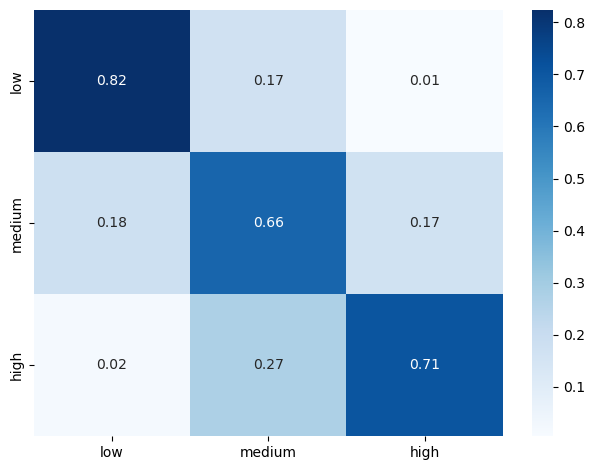

In [41]:
cm = confusion_matrix(y_test, y_pred, labels=count_labels, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=name_labels,
            yticklabels=name_labels)
plt.tight_layout()

In [110]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.7281947261663286

In [102]:
def evaluate_predictions(y_test, y_pred):
    accuracy = sum([yp == yt for yp, yt in zip(y_pred, y_test)]) * 100 / len(y_test)
    return accuracy


accuracy = evaluate_predictions(y_test, y_pred)
print(f"Accuracy on test: {accuracy:.3f}")

Accuracy on test: 74.413


In [391]:
df_raw = pd.read_csv("data/processed/gsm_test.csv", index_col=0)

y_df = pd.DataFrame({"true": y_test, "pred": y_pred}, dtype=int, index=X_test.index)

In [331]:
gt_label = 1
p_label = 2

y_single = y_df[y_df.true == gt_label]
print(f"Number of rows: {len(y_single)}")

y_wrong = y_single[(y_single.pred == p_label)]
print(f"Number of rows: {len(y_wrong)}")

print(f"Ratio: {len(y_wrong)/len(y_single) * 100:.2f}%")

df_raw.loc[y_wrong.index].misc_price.describe()

Number of rows: 145
Number of rows: 23
Ratio: 15.86%


count     23.000000
mean     348.235948
std       47.251075
min      250.000000
25%      305.000000
50%      360.000000
75%      395.000000
max      410.000000
Name: misc_price, dtype: float64

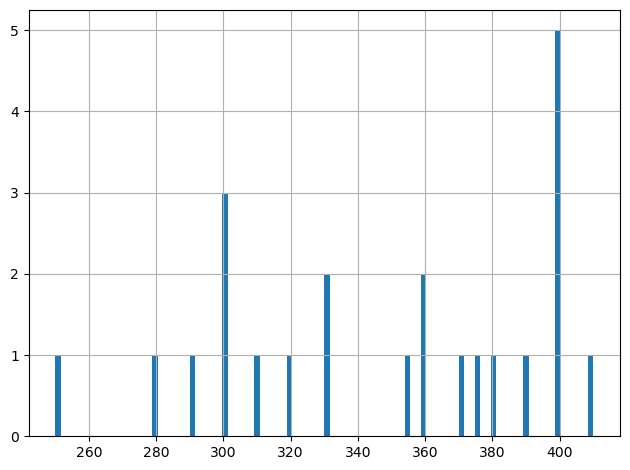

In [332]:
df_raw.loc[y_wrong.index].misc_price.hist(bins=100)
plt.tight_layout()

In [333]:
tmp_df = df_raw.loc[y_wrong.index]
# tmp_df[tmp_df.misc_price < 220].launch_announced.value_counts()
tmp_df.launch_announced.value_counts()

2018.0    6
2019.0    5
2017.0    4
2016.0    3
2020.0    3
2015.0    1
2014.0    1
Name: launch_announced, dtype: int64

#### Evaluate performance on training set

              precision    recall  f1-score   support

         low       0.83      0.85      0.84       716
      medium       0.72      0.71      0.72       593
 medium-high       0.77      0.71      0.74       213

    accuracy                           0.78      1522
   macro avg       0.77      0.76      0.76      1522
weighted avg       0.78      0.78      0.78      1522



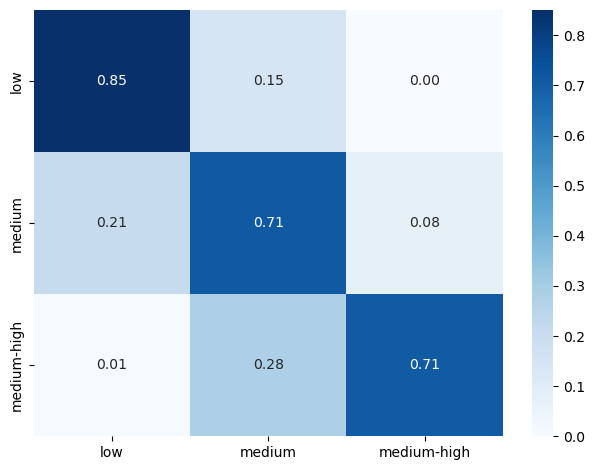

In [425]:
y_pred = train_test.test_model(X_train_val.values, 2048)

count_labels, name_labels = [0,1, 2], ["low", "medium", "medium-high"]
print(classification_report(y_train_val, y_pred, labels=count_labels, target_names=name_labels))

cm = confusion_matrix(y_train_val, y_pred, labels=count_labels, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=name_labels,
            yticklabels=name_labels)
plt.tight_layout()

In [402]:
df_raw = pd.read_csv("data/processed/gsm_train.csv", index_col=0)
df_raw.head(n=3)

y_df = pd.DataFrame({"true": y_train_val, "pred": y_pred}, dtype=int, index=X_train_val.index)

In [403]:
gt_label = 2
p_label = 1

y_single = y_df[y_df.true == gt_label]
print(f"Number of rows: {len(y_single)}")

y_wrong = y_single[(y_single.pred == p_label)]
print(f"Number of rows: {len(y_wrong)}")

print(f"Ratio: {len(y_wrong)/len(y_single) * 100:.2f}%")

Number of rows: 213
Number of rows: 52
Ratio: 24.41%


In [404]:
df_raw.loc[y_wrong.index].misc_price.describe()

count     52.000000
mean     466.581994
std       44.568688
min      420.000000
25%      437.500000
50%      450.000000
75%      499.250000
max      580.000000
Name: misc_price, dtype: float64

<Axes: >

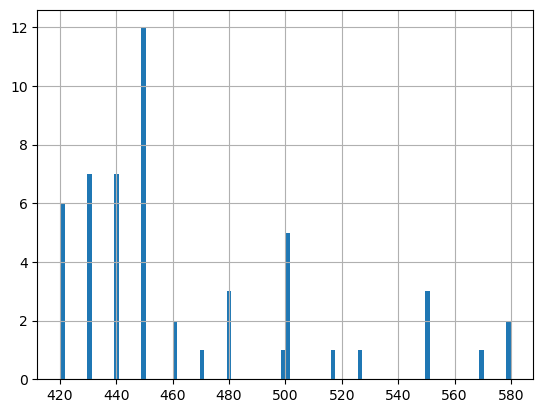

In [405]:
df_raw.loc[y_wrong.index].misc_price.hist(bins=100)

In [419]:
df_raw.loc[y_wrong.index].to_csv("tmp.csv")

## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

In [17]:
from utils import util_counterfactual

Import the pipeline from the pickle to compute the inverse transformation of the features.

In [18]:
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

### Generate counterfactuals with DiCE and Omlt

Using the following functions you're allowed to generate a counterfactual simply passing the model, the counterfactual class (Omlt or Dice), the parameters to run the counterfactual generation and the sample for which to create a counterfactual.

In [19]:
from utils.util_models import evaluate_sample, get_correct_wrong_predictions
from utils.util_counterfactual import generate_counterfactual_from_sample, generate_counterfactuals_from_sample_list

First of all we compute the indexes of the correctly predicted samples and the ones of the wrongly predicted samples such that we can perform two different analyses.

In [20]:
corr_ind, wrong_ind = get_correct_wrong_predictions(nn_model, X_test, y_test)
print(f"The correctly predicted samples are {len(corr_ind)}/{len(corr_ind)+len(wrong_ind)}.")

The correctly predicted samples are 285/383.


In [21]:
cont_feat = [
    "display_size", "battery", "memory_ram_gb", 
    "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
cat_feat = X_train_val.columns.drop(cont_feat).tolist()

cont_feat = [(X_train_val.columns.get_loc(feat), feat) for feat in cont_feat]
cat_feat = [(X_train_val.columns.get_loc(feat), feat) for feat in cat_feat]

print(f"Continuous features: {cont_feat}")
print(f"Categorical features: {cat_feat}")

weights = np.repeat(1, len(cont_feat) + len(cat_feat))
print(f"Sum of weights: {np.sum(weights)} with {len(weights)} weights.")

feature_props = util_counterfactual.create_feature_props(X_train_val, cont_feat, cat_feat, weights)

Continuous features: [(0, 'display_size'), (1, 'battery'), (2, 'memory_ram_gb'), (3, 'memory_rom_gb'), (4, 'main_camera_resolution'), (5, 'selfie_camera_resolution')]
Categorical features: [(6, 'display_resolution'), (7, 'network_technology'), (8, 'num_main_camera'), (9, 'has_oled_display'), (10, 'has_memory_card_slot'), (11, 'has_stereo_speakers'), (12, 'has_3.5mm_jack'), (13, 'has_wlan_5ghz'), (14, 'has_nfc'), (15, 'has_wireless_charging'), (16, 'is_waterproof')]
Sum of weights: 17 with 17 weights.


In [22]:
low_test_idx = y_test[y_test == 0].index.intersection(corr_ind)
medium_test_idx = y_test[y_test == 1].index.intersection(corr_ind)
high_test_idx = y_test[y_test == 2].index.intersection(corr_ind)

#### Counterfactual generation with DiCE

In this case we need to pass as continuous features all the numerical ones (all the features), otherwise Dice will convert the values to strings. 

We may use the genetic method to generate the counterfactuals because is the fastest one available in Dice.

In [ ]:
kwargs_cf_dice = {
    "target" : "misc_price",
    "n_cf" : 1,
    "verbose": False
}

In [23]:
cfs = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train, y_train, X_test.loc[corr_ind], y_test.loc[corr_ind], feature_props=feature_props,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename="correct_cf_dice.csv", **kwargs_cf_dice
)

[0] Generating counterfactual for sample 314.


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


[1] Generating counterfactual for sample 1861.


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


[2] Generating counterfactual for sample 1339.


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


[3] Generating counterfactual for sample 664.


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


[4] Generating counterfactual for sample 918.


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


[5] Generating counterfactual for sample 696.


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


[6] Generating counterfactual for sample 184.


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


[7] Generating counterfactual for sample 1549.


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


[8] Generating counterfactual for sample 1228.


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


[9] Generating counterfactual for sample 1098.


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


[10] Generating counterfactual for sample 1429.


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


[11] Generating counterfactual for sample 330.


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


[12] Generating counterfactual for sample 1076.


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


[13] Generating counterfactual for sample 645.


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


[14] Generating counterfactual for sample 1095.


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


[15] Generating counterfactual for sample 1031.


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


[16] Generating counterfactual for sample 1832.


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


[17] Generating counterfactual for sample 1109.


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


[18] Generating counterfactual for sample 1629.


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


[19] Generating counterfactual for sample 584.


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


[20] Generating counterfactual for sample 713.


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


[21] Generating counterfactual for sample 102.


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Counterfactual not found for the sample Int64Index([102], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[22] Generating counterfactual for sample 569.


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


[23] Generating counterfactual for sample 1010.


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


[24] Generating counterfactual for sample 114.


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


[25] Generating counterfactual for sample 120.


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


[26] Generating counterfactual for sample 1890.


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


[27] Generating counterfactual for sample 1818.


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Counterfactual not found for the sample Int64Index([1818], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[28] Generating counterfactual for sample 1337.


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


[29] Generating counterfactual for sample 1068.


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


[30] Generating counterfactual for sample 656.


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


[31] Generating counterfactual for sample 744.


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


[32] Generating counterfactual for sample 1310.


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


[33] Generating counterfactual for sample 914.


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


[34] Generating counterfactual for sample 1266.


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


[35] Generating counterfactual for sample 1534.


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


[36] Generating counterfactual for sample 689.


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Counterfactual not found for the sample Int64Index([689], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[37] Generating counterfactual for sample 897.


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


[38] Generating counterfactual for sample 125.


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


[39] Generating counterfactual for sample 69.


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


[40] Generating counterfactual for sample 1780.


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


[41] Generating counterfactual for sample 88.


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


[42] Generating counterfactual for sample 986.


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


[43] Generating counterfactual for sample 339.


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


[44] Generating counterfactual for sample 446.


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


[45] Generating counterfactual for sample 1360.


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


[46] Generating counterfactual for sample 1038.


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


[47] Generating counterfactual for sample 1205.


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


[48] Generating counterfactual for sample 1150.


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


[49] Generating counterfactual for sample 1516.


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


[50] Generating counterfactual for sample 141.


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


[51] Generating counterfactual for sample 535.


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


[52] Generating counterfactual for sample 218.


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


[53] Generating counterfactual for sample 1545.


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


[54] Generating counterfactual for sample 583.


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


[55] Generating counterfactual for sample 1002.


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


[56] Generating counterfactual for sample 1162.


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


[57] Generating counterfactual for sample 1741.


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


[58] Generating counterfactual for sample 214.


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


[59] Generating counterfactual for sample 1117.


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


[60] Generating counterfactual for sample 1585.


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


[61] Generating counterfactual for sample 777.


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


[62] Generating counterfactual for sample 1571.


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


[63] Generating counterfactual for sample 1668.


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


[64] Generating counterfactual for sample 748.


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Counterfactual not found for the sample Int64Index([748], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[65] Generating counterfactual for sample 489.


100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


[66] Generating counterfactual for sample 1691.


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

[67] Generating counterfactual for sample 1735.



100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


[68] Generating counterfactual for sample 1016.


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


[69] Generating counterfactual for sample 359.


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


[70] Generating counterfactual for sample 636.


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


[71] Generating counterfactual for sample 1383.


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


[72] Generating counterfactual for sample 1648.


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


[73] Generating counterfactual for sample 1006.


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


[74] Generating counterfactual for sample 1465.


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Counterfactual not found for the sample Int64Index([1465], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[75] Generating counterfactual for sample 778.


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


[76] Generating counterfactual for sample 418.


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


[77] Generating counterfactual for sample 754.


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


[78] Generating counterfactual for sample 1140.


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


[79] Generating counterfactual for sample 1120.


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


[80] Generating counterfactual for sample 978.


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


[81] Generating counterfactual for sample 1812.


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


[82] Generating counterfactual for sample 68.


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


[83] Generating counterfactual for sample 850.


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


[84] Generating counterfactual for sample 1509.


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


[85] Generating counterfactual for sample 289.


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


[86] Generating counterfactual for sample 1716.


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


[87] Generating counterfactual for sample 240.


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


[88] Generating counterfactual for sample 1104.


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


[89] Generating counterfactual for sample 932.


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


[90] Generating counterfactual for sample 618.


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


[91] Generating counterfactual for sample 304.


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


[92] Generating counterfactual for sample 801.


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


[93] Generating counterfactual for sample 210.


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


[94] Generating counterfactual for sample 785.


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


[95] Generating counterfactual for sample 1367.


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


[96] Generating counterfactual for sample 922.


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


[97] Generating counterfactual for sample 161.


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


[98] Generating counterfactual for sample 973.


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


[99] Generating counterfactual for sample 686.


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


[100] Generating counterfactual for sample 861.


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


[101] Generating counterfactual for sample 211.


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


[102] Generating counterfactual for sample 570.


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


[103] Generating counterfactual for sample 1042.


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


[104] Generating counterfactual for sample 1718.


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


[105] Generating counterfactual for sample 268.


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


[106] Generating counterfactual for sample 1079.


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


[107] Generating counterfactual for sample 329.


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


[108] Generating counterfactual for sample 1802.


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


[109] Generating counterfactual for sample 1572.


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


[110] Generating counterfactual for sample 1660.


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


[111] Generating counterfactual for sample 1040.


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


[112] Generating counterfactual for sample 119.


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


[113] Generating counterfactual for sample 615.


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


[114] Generating counterfactual for sample 1870.


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


[115] Generating counterfactual for sample 987.


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


[116] Generating counterfactual for sample 1425.


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


[117] Generating counterfactual for sample 800.


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


[118] Generating counterfactual for sample 1686.


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


[119] Generating counterfactual for sample 588.


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


[120] Generating counterfactual for sample 74.


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


[121] Generating counterfactual for sample 1023.


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


[122] Generating counterfactual for sample 1428.


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


[123] Generating counterfactual for sample 338.


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


[124] Generating counterfactual for sample 1394.


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


[125] Generating counterfactual for sample 309.


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


[126] Generating counterfactual for sample 501.


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


[127] Generating counterfactual for sample 87.


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


[128] Generating counterfactual for sample 1458.


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Counterfactual not found for the sample Int64Index([1458], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[129] Generating counterfactual for sample 1341.


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


[130] Generating counterfactual for sample 767.


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


[131] Generating counterfactual for sample 1751.


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


[132] Generating counterfactual for sample 1745.


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


[133] Generating counterfactual for sample 542.


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


[134] Generating counterfactual for sample 862.


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


[135] Generating counterfactual for sample 1482.


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


[136] Generating counterfactual for sample 1771.


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


[137] Generating counterfactual for sample 855.


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


[138] Generating counterfactual for sample 1664.


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


[139] Generating counterfactual for sample 1053.


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


[140] Generating counterfactual for sample 746.


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


[141] Generating counterfactual for sample 1326.


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


[142] Generating counterfactual for sample 659.


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


[143] Generating counterfactual for sample 287.


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


[144] Generating counterfactual for sample 1773.


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


[145] Generating counterfactual for sample 545.


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


[146] Generating counterfactual for sample 1850.


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


[147] Generating counterfactual for sample 1406.


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

[148] Generating counterfactual for sample 462.



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


[149] Generating counterfactual for sample 1840.


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


[150] Generating counterfactual for sample 497.


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


[151] Generating counterfactual for sample 1654.


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


[152] Generating counterfactual for sample 1250.


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

[153] Generating counterfactual for sample 1865.



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


[154] Generating counterfactual for sample 944.


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


[155] Generating counterfactual for sample 1378.


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


[156] Generating counterfactual for sample 647.


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


[157] Generating counterfactual for sample 1066.


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


[158] Generating counterfactual for sample 1641.


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


[159] Generating counterfactual for sample 372.


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Counterfactual not found for the sample Int64Index([372], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[160] Generating counterfactual for sample 1073.


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


[161] Generating counterfactual for sample 1009.


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


[162] Generating counterfactual for sample 1215.


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


[163] Generating counterfactual for sample 1292.


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


[164] Generating counterfactual for sample 1245.


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


[165] Generating counterfactual for sample 194.


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

[166] Generating counterfactual for sample 508.

100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


[167] Generating counterfactual for sample 1017.


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


[168] Generating counterfactual for sample 450.


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


[169] Generating counterfactual for sample 949.


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


[170] Generating counterfactual for sample 1253.


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


[171] Generating counterfactual for sample 1851.


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


[172] Generating counterfactual for sample 628.


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


[173] Generating counterfactual for sample 843.


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


[174] Generating counterfactual for sample 1889.


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Counterfactual not found for the sample Int64Index([1889], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[175] Generating counterfactual for sample 738.


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Counterfactual not found for the sample Int64Index([738], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.
[176] Generating counterfactual for sample 1220.


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


[177] Generating counterfactual for sample 1743.


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


[178] Generating counterfactual for sample 1700.


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


[179] Generating counterfactual for sample 1452.


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


[180] Generating counterfactual for sample 333.


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


[181] Generating counterfactual for sample 1761.


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


[182] Generating counterfactual for sample 1580.


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


[183] Generating counterfactual for sample 271.


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


[184] Generating counterfactual for sample 400.


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


[185] Generating counterfactual for sample 1769.


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

[186] Generating counterfactual for sample 341.



100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


[187] Generating counterfactual for sample 1237.


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


[188] Generating counterfactual for sample 1271.


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


[189] Generating counterfactual for sample 704.


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


[190] Generating counterfactual for sample 1151.


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


[191] Generating counterfactual for sample 762.


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


[192] Generating counterfactual for sample 1445.


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


[193] Generating counterfactual for sample 1035.


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


[194] Generating counterfactual for sample 1723.


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


[195] Generating counterfactual for sample 1265.


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


[196] Generating counterfactual for sample 133.


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


[197] Generating counterfactual for sample 485.


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


[198] Generating counterfactual for sample 105.


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


[199] Generating counterfactual for sample 1711.


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


[200] Generating counterfactual for sample 388.


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

[201] Generating counterfactual for sample 708.

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


[202] Generating counterfactual for sample 1845.


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


[203] Generating counterfactual for sample 116.


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

[204] Generating counterfactual for sample 1344.



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


[205] Generating counterfactual for sample 821.


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


[206] Generating counterfactual for sample 473.


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


[207] Generating counterfactual for sample 429.


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


[208] Generating counterfactual for sample 31.


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


[209] Generating counterfactual for sample 1899.


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


[210] Generating counterfactual for sample 33.


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


[211] Generating counterfactual for sample 1145.


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


[212] Generating counterfactual for sample 595.


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


[213] Generating counterfactual for sample 40.


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


[214] Generating counterfactual for sample 1335.


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


[215] Generating counterfactual for sample 1183.


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


[216] Generating counterfactual for sample 828.


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


[217] Generating counterfactual for sample 1072.


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


[218] Generating counterfactual for sample 1127.


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

[219] Generating counterfactual for sample 1562.



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


[220] Generating counterfactual for sample 1866.


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


[221] Generating counterfactual for sample 979.


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


[222] Generating counterfactual for sample 1290.


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


[223] Generating counterfactual for sample 839.


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


[224] Generating counterfactual for sample 1900.


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


[225] Generating counterfactual for sample 1258.


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


[226] Generating counterfactual for sample 1806.


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

[227] Generating counterfactual for sample 1291.



100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

[228] Generating counterfactual for sample 1742.



100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


[229] Generating counterfactual for sample 185.


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


[230] Generating counterfactual for sample 303.


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


[231] Generating counterfactual for sample 1816.


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


[232] Generating counterfactual for sample 1362.


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


[233] Generating counterfactual for sample 803.


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


[234] Generating counterfactual for sample 1797.


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


[235] Generating counterfactual for sample 352.


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


[236] Generating counterfactual for sample 291.


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


[237] Generating counterfactual for sample 499.


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


[238] Generating counterfactual for sample 971.


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


[239] Generating counterfactual for sample 42.


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


[240] Generating counterfactual for sample 1524.


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

[241] Generating counterfactual for sample 1391.



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


[242] Generating counterfactual for sample 459.


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


[243] Generating counterfactual for sample 1504.


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


[244] Generating counterfactual for sample 1877.


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


[245] Generating counterfactual for sample 1101.


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

[246] Generating counterfactual for sample 249.



100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


[247] Generating counterfactual for sample 1148.


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


[248] Generating counterfactual for sample 1282.


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


[249] Generating counterfactual for sample 1689.


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


[250] Generating counterfactual for sample 1476.


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


[251] Generating counterfactual for sample 587.


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


[252] Generating counterfactual for sample 443.


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


[253] Generating counterfactual for sample 1247.


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


[254] Generating counterfactual for sample 1543.


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


[255] Generating counterfactual for sample 1005.


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


[256] Generating counterfactual for sample 505.


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


[257] Generating counterfactual for sample 1611.


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


[258] Generating counterfactual for sample 1058.


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


[259] Generating counterfactual for sample 225.


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


[260] Generating counterfactual for sample 1106.


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


[261] Generating counterfactual for sample 698.


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


[262] Generating counterfactual for sample 351.


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


[263] Generating counterfactual for sample 16.


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


[264] Generating counterfactual for sample 406.


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


[265] Generating counterfactual for sample 162.


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


[266] Generating counterfactual for sample 1336.


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


[267] Generating counterfactual for sample 1219.


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


[268] Generating counterfactual for sample 71.


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


[269] Generating counterfactual for sample 1507.


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


[270] Generating counterfactual for sample 511.


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


[271] Generating counterfactual for sample 703.


100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


[272] Generating counterfactual for sample 1893.


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


[273] Generating counterfactual for sample 804.


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


[274] Generating counterfactual for sample 619.


100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


[275] Generating counterfactual for sample 651.


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


[276] Generating counterfactual for sample 1519.


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


[277] Generating counterfactual for sample 694.


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


[278] Generating counterfactual for sample 1681.


100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


[279] Generating counterfactual for sample 1835.


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


[280] Generating counterfactual for sample 980.


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


[281] Generating counterfactual for sample 1493.


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


[282] Generating counterfactual for sample 404.


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


[283] Generating counterfactual for sample 296.


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


[284] Generating counterfactual for sample 1481.


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


In [20]:
try:
    cfs_list = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train_val, y_train_val, X_test.loc[corr_ind], 
        y_test.loc[corr_ind], feature_props, type_cf="lower", backend="PYT",
        target_column="misc_price", dice_method="genetic", pipeline=cols_pipeline, 
        save_filename="data/counterfactual/corr_cf_dice.csv", **kwargs_cf_dice
    )
except AssertionError as e:
    print(f"{type(e).__name__} - Check the passed arguments: {e}")
except ValueError as e:
    print(f"{type(e).__name__} Check the passed arguments: {e}")

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Counterfactual not found for the sample Int64Index([1818], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Counterfactual not found for the sample Int64Index([689], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Counterfactual not found for the sample Int64Index([748], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Counterfactual not found for the sample Int64Index([1465], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Counterfactual not found for the sample Int64Index([372], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Counterfactual not found for the sample Int64Index([738], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Counterfactual not found for the sample Int64Index([1681], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Counterfactual not found for the sample Int64Index([296], dtype='int64').
No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


#### Counterfactual generation with OMLT

When we initialize the OMLT class we need to specify which are the continuous features, such that it can set the correct domains and bounds for the Pyomo variables.


We can pass different parameters to generate a counterfactual, such as the minimum probability required for the counterfactual, the weights for the objective functions, the weights for the features, because some features are more expensive to be changed than the others. As last thing, we can tell the model not to change some features of the original sample.

- Constraints and variables
  - $input_i$: input value of feature $i$
  - $sample_i$: sample value for feature $i$
  - $output_i$: output value for label $i$

- Discrete features
  - Sets
    - $D$: set of discrete variables
    - $M_i$: number of possible values for discrete variable $i$
  - Variables
    - $v_{i,j}$: value of discrete variable $i$ for its $j$-th possible value
    - $discrete_{i,j} \in \{0, 1\}$: binary variable indicating whether the $j$-th possible value of discrete variable $i$ is selected 
  - Constraints
    - $\sum_j^{M_i} discrete_{i,j} = 1, \forall i \in D$
    - $input_i = \sum_j^{m_i} v_{i,j} \cdot discrete_{i,j}, \forall i \in D$

- Absolute distances between sample and counterfactual
  - Sets
    - $F$: set of features
    - $R_i$: range of feature $i$
  - Variables
    - $b_i \in \{0, 1\}$: binary variable indicating weather the distance is positive or negative
    - $distance_i$: absolute distance between sample and counterfactual for feature $i$
  - Constraints
    - $input_i - sample_i \leq R_i \cdot b_i, \forall i \in F$
    - $sample_i - input_i \leq R_i \cdot (1 - b_i), \forall i \in F$
    - $input_i - sample_i \leq distance_i, \forall i \in F$
    - $sample_i - input_i \leq distance_i, \forall i \in F$
    - $distance_i \leq input_i - sample_i + 2 \cdot R_i \cdot (1 - b_i), \forall i \in F$
    - $distance_i \leq sample_i - input_i + 2 \cdot R_i \cdot b_i, \forall i \in F$

- Gower distance between sample and counterfactual
  - Variables
    - $weight_i$: weight of feature $i$
    - $gower$: Gower distance between sample and counterfactual
  - Constraints
    - $gower = \frac{1}{|F|} \sum_i^F \frac{1}{R_i} \cdot distance_i * weight_i$

- Number of features changed
  - Variables
    - $change_i \in \{0, 1\}$: binary variable indicating whether feature $i$ is changed
  - Constraints
    - $distance_i \geq change_i - 1 + \epsilon, \forall i \in F$
    - $distance_i \leq change_i \cdot R_i, \forall i \in F$
    - $changed = \sum_i^F change_i$

- Counterfactual label
  - Sets
    - $L$: set of labels
    - $cf$: counterfactual label
  - Constraints
    - $output_{cf} = 1.1 \cdot output_i, \forall i \in L \setminus \{cf\}$

In [61]:
solver_opt_mindtpy = {
    "time_limit": 60,
    "strategy": "OA",
    "add_regularization": "level_L2",
    "threads": 8,
    "mip_solver_args": dict(warmstart=True),
    "use_bb_tree_incumbent": True,
    "calculate_dual_at_solution": True,
    "cycling_check": True,
    "obj_bound": 10 
}
solver_opt_cplex = {
    "mip display": 0,
    "timelimit": 60
}

kwargs_cf_omlt = {
    "min_probability" : 0.6, 
    "obj_weights" : [1, 1, 0.2],
    # "solver": "mindtpy",
    "solver": "cplex",
    "solver_options" : solver_opt_cplex,
    "verbose": False
}

A marginal softmax computation is performed to compute the probability of the target class with log-linear complexity. However, instead of giving a probability distribution over the target class, it is more similar to a loss, which is minimized.

The minimum value of the marginal softmax for misclassified samples is approximately 0.70, thus a threshold of 0.70 or lower is used to find the counterfactuals.

Minimum value of misclassified samples: 0.696


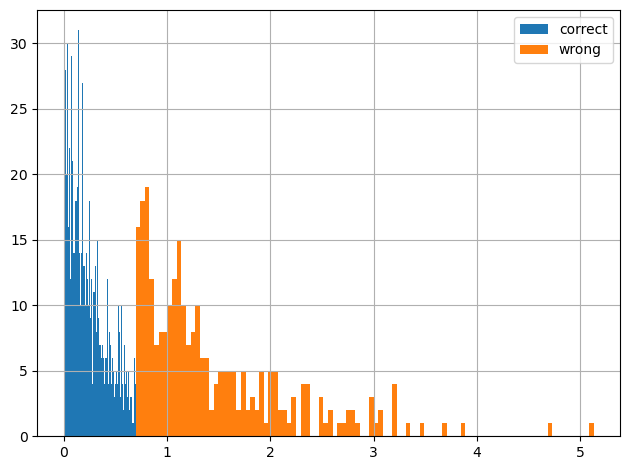

In [26]:
# compute marginal softmax
correct_diff, wrong_diff = util_counterfactual.difference_log_softmax(nn_model, X_train, y_train, device)
print(f"Minimum value of misclassified samples: {np.min(wrong_diff):.3f}")

# plot histogram
pd.Series(correct_diff).hist(bins=100, label="correct")
pd.Series(wrong_diff).hist(bins=100, label="wrong")
plt.legend()
plt.tight_layout()

Test counterfactuals misclassified by the model. A small change in the features should lead to a change in the prediction.

In [62]:
try:
    cfs_list = generate_counterfactuals_from_sample_list(
        nn_model, "omlt", X_train_val, y_train_val, X_test.loc[wrong_ind], 
        y_test.loc[wrong_ind], feature_props, type_cf="same", 
        target_column="misc_price", pipeline=cols_pipeline, save_filename="same_omlt_alt.csv", **kwargs_cf_omlt)
except AssertionError as e:
    print(f"{type(e).__name__} - Check the passed arguments: {e}")
except ValueError as e:
    print(f"{type(e).__name__} Check the passed arguments: {e}")

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[0] Generating counterfactual for sample 868.
Time elapsed: 14.487010955810547 seconds.
[1] Generating counterfactual for sample 771.
Time elapsed: 8.847962856292725 seconds.
[2] Generating counterfactual for sample 1672.
Time elapsed: 4.6130852699279785 seconds.
[3] Generating counterfactual for sample 1597.
Time elapsed: 7.072012901306152 seconds.
[4] Generating counterfactual for sample 1030.
Time elapsed: 4.461806297302246 seconds.
[5] Generating counterfactual for sample 877.
Time elapsed: 23.325254678726196 seconds.
[6] Generating counterfactual for sample 599.
Time elapsed: 22.100376844406128 seconds.
[7] Generating counterfactual for sample 1459.
Time elapsed: 5.002075672149658 seconds.
[8] Generating counterfactual for sample 790.
Time elapsed: 19.615150928497314 seconds.
[9] Ge

Test counterfactuals correctly classified by the model.

In [63]:
try:
    cfs_list = generate_counterfactuals_from_sample_list(
        nn_model, "omlt", X_train_val, y_train_val, X_test.loc[corr_ind], 
        y_test.loc[corr_ind], feature_props, type_cf="increase", 
        target_column="misc_price", pipeline=cols_pipeline, save_filename="all_omlt.csv", **kwargs_cf_omlt)
except AssertionError as e:
    print(f"{type(e).__name__} - Check the passed arguments: {e}")
except ValueError as e:
    print(f"{type(e).__name__} Check the passed arguments: {e}")

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[0] Generating counterfactual for sample 314.
Time elapsed: 26.35429334640503 seconds.
[1] Generating counterfactual for sample 1861.
Time elapsed: 9.88337230682373 seconds.
[2] Generating counterfactual for sample 1339.
Time elapsed: 7.974075794219971 seconds.
[3] Generating counterfactual for sample 664.
Time elapsed: 5.604962348937988 seconds.
[4] Generating counterfactual for sample 918.
Time elapsed: 61.32843732833862 seconds.
[5] Generating counterfactual for sample 696.
Time elapsed: 34.32943844795227 seconds.
[6] Generating counterfactual for sample 184.
Time elapsed: 5.499780893325806 seconds.
[7] Generating counterfactual for sample 1549.
Time elapsed: 5.325855493545532 seconds.
[8] Generating counterfactual for sample 1228.
Time elapsed: 61.299325704574585 seconds.
[9] Generat

In [64]:
try:
    cfs_list = generate_counterfactuals_from_sample_list(
        nn_model, "omlt", X_train_val, y_train_val, X_test.loc[medium_test_idx], 
        y_test.loc[medium_test_idx], feature_props, type_cf="lower", 
        target_column="misc_price", pipeline=cols_pipeline, save_filename="medium_low.csv", **kwargs_cf_omlt)
except AssertionError as e:
    print(f"{type(e).__name__} - Check the passed arguments: {e}")
except ValueError as e:
    print(f"{type(e).__name__} Check the passed arguments: {e}")

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[0] Generating counterfactual for sample 314.
Time elapsed: 61.37435054779053 seconds.
[1] Generating counterfactual for sample 1861.
The counterfactual is the same as a sample of zeros.
Time elapsed: 61.30430579185486 seconds.
[2] Generating counterfactual for sample 1339.
Time elapsed: 61.407015323638916 seconds.
[3] Generating counterfactual for sample 918.
Time elapsed: 10.346307754516602 seconds.
[4] Generating counterfactual for sample 1429.
Time elapsed: 60.33389973640442 seconds.
[5] Generating counterfactual for sample 1031.
Time elapsed: 61.37073850631714 seconds.
[6] Generating counterfactual for sample 1109.
Time elapsed: 61.32752203941345 seconds.
[7] Generating counterfactual for sample 1629.
Time elapsed: 12.239516973495483 seconds.
[8] Generating counterfactual for sample

### Further experiments

In [75]:
from utils.util_base_cf import inverse_pipeline

In [ ]:
cont_feat = [
    "display_size", "battery", "memory_ram_gb", 
    "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
cat_feat = X_train_val.columns.drop(cont_feat).tolist()

cont_feat = [(X_train_val.columns.get_loc(feat), feat) for feat in cont_feat]
cat_feat = [(X_train_val.columns.get_loc(feat), feat) for feat in cat_feat]

print(f"Continuous features: {cont_feat}")
print(f"Categorical features: {cat_feat}")


Options for DiCE

In [ ]:
kwargs_cf_dice = {
    "target" : "misc_price",
    "n_cf" : 1,
    "verbose": False
}

Options folr OMLT

In [ ]:
solver_opt = {
    "time_limit": 120,
    "strategy": "OA",
    "add_regularization": "level_L2",
    "threads": 8,
    "mip_solver_args": dict(warmstart=True),
    "use_bb_tree_incumbent": True,
    "calculate_dual_at_solution": True,
    "cycling_check": True,
    "obj_bound": 10 
}
kwargs_cf_omlt = {
    "min_probability" : 0.6, 
    "obj_weights" : [1, 0.4, 0.1],
    "solver": "mindtpy",
    "solver_options" : solver_opt,
    "verbose": False
}

#### Fix some features

We can also decide to fix some features such that they cannot be changed during the generation, but the model may not be able to find a counterfactual if it needs that features.

In [15]:
# Set all the weights to 1
weights = np.repeat(1, len(cont_feat) + len(cat_feat))

We know that the most changed features in DiCE are 'battery', 'display_size', 'memory_ram_gb', 'selfie_camera_resolution', 'memory_rom_gb' and 'main_camera_resolution'. In Omlt the list of features is the same and in addition there is 'display_resolution'.

For this reason it seems reasonable to fix these features in different combinations and try to understand how the model behaves.

In [79]:
features_to_fix = ['battery', 'display_size', 'memory_ram_gb', 'selfie_camera_resolution', 'memory_rom_gb', 'main_camera_resolution']
feature_props = util_counterfactual.create_feature_props(X_train_val, cont_feat, cat_feat, weights, features_to_fix)

weights = np.repeat(1, len(cont_feat) + len(cat_feat))
print(f"Sum of weights: {np.sum(weights)} with {len(weights)} weights.")

feature_props = util_counterfactual.create_feature_props(X_train_val, cont_feat, cat_feat, weights, to_fix=)

Our analysis is performed on the correctly predicted samples, therefore we take some indexes from the "corr_ind" list. 

Examples: 314, 1861, 1339, 664, 918, 696

In [80]:
idx = 314

sample_idx = X_test.loc[[idx]]
label_idx = y_test.loc[[idx]]

In [81]:
cfs = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train_val, y_train_val, sample_idx, label_idx, feature_props=feature_props,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


In [82]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe generated counterfactual is:")
display(cfs)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,26.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The generated counterfactual is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.3,4049.999973,4.0,63.999999,25.0,13.0,FHD,4G,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


#### Change the weights of the features

First of all we check what is a default counterfactual generated by DiCE using the same weights for each element, then we test if increasing the weights the model doesn't change them anymore (or less).

In [85]:
idx = 314

sample_idx = X_test.loc[[idx]]
label_idx = y_test.loc[[idx]]

weights = np.repeat(1, len(cont_feat) + len(cat_feat))
feature_props = util_counterfactual.create_feature_props(X_train_val, cont_feat, cat_feat, weights)

In [86]:
cfs = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train_val, y_train_val, sample_idx, label_idx, feature_props=feature_props,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)
cfs

100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.21,3399.999961,3.0,63.999999,3.0,2.0,FHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [102]:
# Set different weights
weights = np.repeat(1, len(cont_feat) + len(cat_feat))
# weights[X_train_val.columns.get_loc("memory_ram_gb")] = 1
weights[X_train_val.columns.get_loc("selfie_camera_resolution")] = 2
weights[X_train_val.columns.get_loc("battery")] = 2
# weights[X_train_val.columns.get_loc("main_camera_resolution")] = 1

feature_props = util_counterfactual.create_feature_props(X_train_val, cont_feat, cat_feat, weights)

In [103]:
cfs_w = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train_val, y_train_val, sample_idx, label_idx, feature_props=feature_props,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


In [104]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe counterfactual computed with the same weights is:")
display(cfs)
print("\nThe generated counterfactual with different weights is:")
display(cfs_w)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,26.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The counterfactual computed with the same weights is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.21,3399.999961,3.0,63.999999,3.0,2.0,FHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0



The generated counterfactual with different weights is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.36,4000.000042,3.0,32.0,17.0,13.0,FHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


As you can see, if we increase the weights for some features the model tends to change them less.